Trabajo final del curso de Data Science realizado en Febrero 2021.


Se trabajó con un dataset armado con la API de Spotify, para obtener la información de las canciones, y la API de Genius, de la cual se consiguieron las letras. 

Se desarrollaron modelos de clasificación para determinar si se podía clasificar el género de una canción a partir de los parámetros que tiene Spotify en su sistema y su letra, y se implementaron modelos de regresión para predecir la valencia de la canción. La valencia es un parámtero que tienen todas las canciones de Spotify y describe la positividad musical que transmite una canción. Las canciones con valencia alta suenan más positivas (p. Ej., Feliz, alegre, eufórico), mientras que las canciones con valencia baja suenan más negativas (p. Ej., Triste, deprimido, enojado)”.

# Índice

### <b><a href="#clasifgen">1. Clasificador de género</a></b>
#### <b><a href="#regresionlog">1.1. Regresion Logistica</a></b>
#### <b><a href="#naive">1.2. Naive Bayes</a></b>
#### <b><a href="#arbol">1.3. Árboles</a></b>

### <b><a href="#valence">2. Predicción de valencia</a></b>
#### <b><a href="#elastic">2.1. ElasticNet</a></b>
#### <b><a href="#lasso">2.2. Lasso</a></b>
#### <b><a href="#ridge">2.3. Ridge</a></b>


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.spatial.distance import pdist,squareform
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc, precision_score, recall_score, r2_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeClassifierCV, LinearRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

# <b><a id="clasifgen">1. Clasificador de género</a></b>

### Lectura del dataset

In [2]:
data = pd.read_csv('./music_sentiments.csv', sep="\t")
data.shape

(3445, 78)

In [3]:
data.head(5)

,genre,artist,album,danceability,energy,loudness,mode,speechiness,instrumentalness,valence,...,anger_quantity,anticipation_quantity,disgust_quantity,fear_quantity,joy_quantity,negative_quantity,positive_quantity,sadness_quantity,surprise_quantity,trust_quantity
0,Pop,Michael Jackson,Thriller 25 Super Deluxe Edition,0.920,0.654,-3.051,0,0.0401,0.015800,0.847,...,3,13,2,0,25,4,30,2,4,17
1,Pop,Michael Jackson,Bad 25th Anniversary,0.853,0.981,-3.947,1,0.0751,0.468000,0.595,...,6,7,2,9,6,14,8,2,6,6
2,Pop,Michael Jackson,Thriller 25 Super Deluxe Edition,0.779,0.867,-3.704,0,0.0457,0.000008,0.915,...,11,2,4,19,1,37,4,19,1,5
3,Pop,Michael Jackson,Bad 25th Anniversary,0.877,0.854,-4.523,1,0.1470,0.000055,0.540,...,12,6,12,17,19,15,23,15,1,5
4,Pop,Michael Jackson,Scream,0.764,0.887,-3.726,1,0.0744,0.000110,0.720,...,16,25,11,31,19,30,21,14,17,13


In [4]:
data.drop(columns=["artist", "album", "tokens", "char_count", "ignore_track", "track_name_clean", "album_release_year"], inplace=True)

<AxesSubplot:>

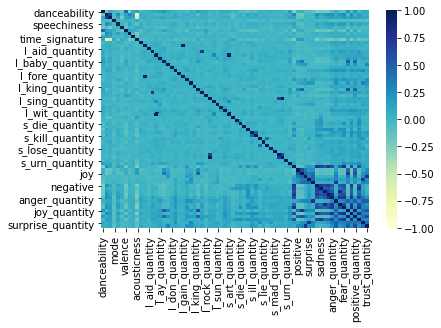

In [5]:
sns.heatmap(data.corr(), vmin=-1, vmax=1, center=0, cmap="YlGnBu")

### Features, Variable Target y Normalización

In [6]:
X = data.drop(columns=["genre"])
y = data["genre"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 0)

In [8]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

### Función para evaluar modelos

In [9]:
def evaluate_model(model,X,y_true):
    '''
    Calcula las métricas ppales para evaluar un clasificador
    Toma como imput el modelo entrenado, el dataset de testeo y sus etiquetas
    '''
    y_pred=model.predict(X)
    y_proba=model.predict_proba(X)

    print(classification_report(y_true,y_pred))
    print('Area bajo la curva ROC:',np.round(roc_auc_score(y_true, y_proba, multi_class="ovo"),4))
    plot_confusion_matrix(model,X,y_true,cmap='Blues');
    return

----------------------------------

## <b><a id="regresionlog">1.1. Regresion Logistica</a></b>

In [10]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_std, y_train)

LogisticRegression(max_iter=1000)

In [11]:
y_pred=lr.predict(X_test_std)
y_proba=lr.predict_proba(X_test_std)

In [12]:
accuracy_score(y_train, lr.predict(X_train_std))

0.7502903600464577

              precision    recall  f1-score   support

 Heavy Metal       0.65      0.60      0.62       202
        Jazz       0.70      0.73      0.72        97
         Pop       0.82      0.86      0.84       195
   Punk Rock       0.57      0.58      0.58       211
 Rock n Roll       0.72      0.72      0.72       157

    accuracy                           0.69       862
   macro avg       0.69      0.70      0.70       862
weighted avg       0.69      0.69      0.69       862

Area bajo la curva ROC: 0.9235


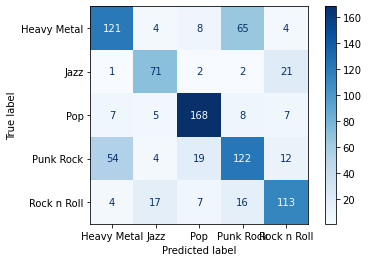

In [13]:
evaluate_model(lr, X_test_std, y_test)

#### <b><a id="regresionloggrid">1.1.2 GridSearch</a></b>

In [14]:
param_grid_lr = {'C': [1, 10, 100, 1000, 10000, 100000],
     'penalty': ["l2"],
     'solver': ['saga', "lbfgs"]}

In [15]:
folds = StratifiedKFold(n_splits=5, random_state=19, shuffle=True)

In [16]:
grid_lr = GridSearchCV(lr, param_grid_lr, cv=folds, scoring='accuracy', n_jobs=-2)

In [17]:
lr_fiteado = grid_lr.fit(X_train_std, y_train)

In [18]:
grid_lr.best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'saga'}

In [19]:
grid_lr.best_score_

0.7069452566236336

              precision    recall  f1-score   support

 Heavy Metal       0.65      0.60      0.62       202
        Jazz       0.70      0.73      0.72        97
         Pop       0.83      0.86      0.84       195
   Punk Rock       0.57      0.58      0.58       211
 Rock n Roll       0.72      0.73      0.72       157

    accuracy                           0.69       862
   macro avg       0.69      0.70      0.70       862
weighted avg       0.69      0.69      0.69       862

Area bajo la curva ROC: 0.9236


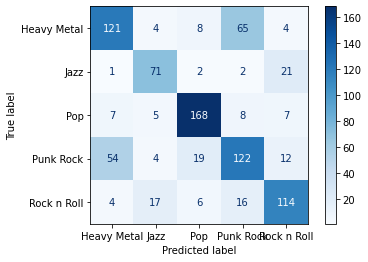

In [20]:
evaluate_model(grid_lr, X_test_std, y_test)

In [21]:
#logistic Regression
resultados_lr = [["Logistic Regression", accuracy_score(y_test,lr.predict(X_test_std)), precision_score(y_test,lr.predict(X_test_std), average="weighted"), recall_score(y_test,lr.predict(X_test_std), average="weighted")]]
resultados = pd.DataFrame(resultados_lr, columns=["modelo", "accuracy", "precision", "recall"])

#Logistic Regression Grid
resultados_grid_lr = [["Logistic Regression Grid", accuracy_score(y_test,grid_lr.predict(X_test_std)), precision_score(y_test,grid_lr.predict(X_test_std), average="weighted"), recall_score(y_test,grid_lr.predict(X_test_std), average="weighted")]]
resultados_grid_lr_df = pd.DataFrame(resultados_grid_lr, columns=["modelo", "accuracy", "precision", "recall"])

#Tabla final
resultados = resultados.append(resultados_grid_lr_df)

----------------------------------

## <b><a id="naive">1.2. Naive Bayes</a></b>

#### 1.2.1. Sin normalización

In [22]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [23]:
y_pred = gnb.predict(X_test)
y_pred_train = gnb.predict(X_train)
print("Accuracy test sin normalizar", accuracy_score(y_test, y_pred))
print("Accuracy train sin normalizar", accuracy_score(y_train, y_pred_train))

Accuracy test sin normalizar 0.4733178654292343
Accuracy train sin normalizar 0.49516066589237323


#### 1.2.2. Con normalización

In [24]:
gnb_std = GaussianNB()
gnb_std.fit(X_train_std, y_train)

GaussianNB()

In [25]:
y_pred_train_std = gnb_std.predict(X_train_std)
print("Accuracy train con normalización", accuracy_score(y_train, y_pred_train_std))

Accuracy train con normalización 0.49516066589237323


              precision    recall  f1-score   support

 Heavy Metal       0.58      0.50      0.54       202
        Jazz       0.43      0.82      0.57        97
         Pop       0.67      0.43      0.52       195
   Punk Rock       0.45      0.24      0.31       211
 Rock n Roll       0.35      0.59      0.44       157

    accuracy                           0.47       862
   macro avg       0.50      0.52      0.48       862
weighted avg       0.51      0.47      0.46       862

Area bajo la curva ROC: 0.8119


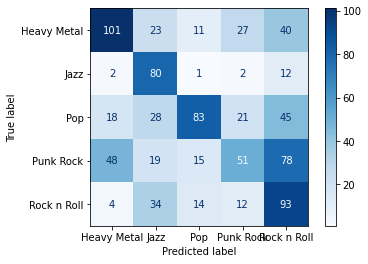

In [26]:
evaluate_model(gnb_std, X_test_std, y_test)

In [27]:
#Naive Bayes
resultados_gnb = [["Naive Bayes", accuracy_score(y_test,gnb.predict(X_test)), precision_score(y_test,gnb.predict(X_test), average="weighted"), recall_score(y_test,gnb.predict(X_test), average="weighted")]]
resultados_gnb_df = pd.DataFrame(resultados_gnb, columns=["modelo", "accuracy", "precision", "recall"])

#Naive Bayes Normalizado
resultados_gnb_std = [["Naive Bayes Normalizado", accuracy_score(y_test,gnb_std.predict(X_test_std)), precision_score(y_test,gnb_std.predict(X_test_std), average="weighted"), recall_score(y_test,gnb_std.predict(X_test_std), average="weighted")]]
resultados_gnb_std_df = pd.DataFrame(resultados_gnb_std, columns=["modelo", "accuracy", "precision", "recall"])

#Tabla final
resultados = resultados.append([resultados_gnb_df,resultados_gnb_std_df])

----------------------------------

## <b><a id="arbol">1.3. Árboles</a></b>

#### 1.3.1. Sin normalización

In [28]:
from sklearn import tree
clftree = tree.DecisionTreeClassifier(random_state=40)

In [29]:
clftree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=40)

In [30]:
y_train_pred_tree = clftree.predict(X_train)
y_test_pred_tree = clftree.predict(X_test)

In [31]:
accuracy_score(y_train, y_train_pred_tree)

1.0

              precision    recall  f1-score   support

 Heavy Metal       0.64      0.52      0.57       202
        Jazz       0.62      0.62      0.62        97
         Pop       0.68      0.67      0.68       195
   Punk Rock       0.48      0.54      0.51       211
 Rock n Roll       0.60      0.68      0.64       157

    accuracy                           0.60       862
   macro avg       0.61      0.60      0.60       862
weighted avg       0.60      0.60      0.60       862

Area bajo la curva ROC: 0.752


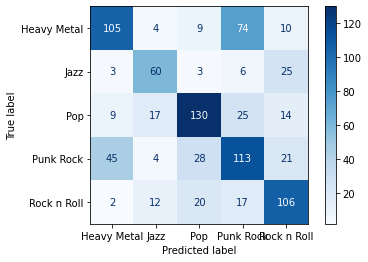

In [32]:
evaluate_model(clftree, X_test, y_test)

#### 1.3.2. Con normalización

In [33]:
clftree_std = tree.DecisionTreeClassifier(random_state=40)

In [34]:
clftree_std.fit(X_train_std, y_train)

DecisionTreeClassifier(random_state=40)

In [35]:
y_train_pred_tree_std = clftree_std.predict(X_train_std)
y_test_pred_tree_std = clftree_std.predict(X_test_std)

In [36]:
accuracy_score(y_train, y_train_pred_tree_std)

1.0

              precision    recall  f1-score   support

 Heavy Metal       0.61      0.55      0.58       202
        Jazz       0.66      0.67      0.66        97
         Pop       0.71      0.67      0.69       195
   Punk Rock       0.46      0.49      0.48       211
 Rock n Roll       0.60      0.67      0.63       157

    accuracy                           0.60       862
   macro avg       0.61      0.61      0.61       862
weighted avg       0.60      0.60      0.60       862

Area bajo la curva ROC: 0.756


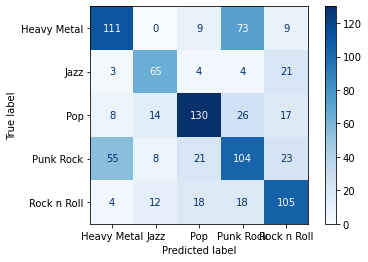

In [37]:
evaluate_model(clftree_std, X_test_std, y_test)

#### 1.3.3. GridSearch

In [38]:
params_grid = { "criterion" : ["gini", "entropy"],
                "min_samples_leaf": [5,10,15,20,None], 
                "max_depth" : [1,2,3,4,5,6,8,9,10,11,12,13,14,None],
                "min_samples_split": [2, 3, 4,None]}

In [39]:
grid_search = GridSearchCV(clftree, params_grid,
                           n_jobs=-2, scoring='accuracy')

In [40]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=40), n_jobs=-2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13,
                                       14, None],
                         'min_samples_leaf': [5, 10, 15, 20, None],
                         'min_samples_split': [2, 3, 4, None]},
             scoring='accuracy')

In [41]:
#Score durante el entrenamiento.
grid_search.best_score_

0.65002474022761

In [42]:
grid_search.best_params_ 

{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [43]:
cv_clf = grid_search.best_estimator_

In [44]:
cv_clf

DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, random_state=40)

              precision    recall  f1-score   support

 Heavy Metal       0.71      0.50      0.59       202
        Jazz       0.58      0.82      0.68        97
         Pop       0.75      0.67      0.70       195
   Punk Rock       0.54      0.66      0.60       211
 Rock n Roll       0.67      0.64      0.66       157

    accuracy                           0.64       862
   macro avg       0.65      0.66      0.65       862
weighted avg       0.66      0.64      0.64       862

Area bajo la curva ROC: 0.8715


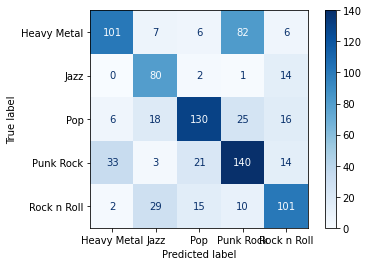

In [45]:
evaluate_model(cv_clf, X_test, y_test)

In [46]:
#Arbol
resultados_tree = [["Arbol", accuracy_score(y_test,clftree.predict(X_test)), precision_score(y_test,clftree.predict(X_test), average="weighted"), recall_score(y_test,clftree.predict(X_test), average="weighted")]]
resultados_tree_df = pd.DataFrame(resultados_tree, columns=["modelo", "accuracy", "precision", "recall"])

#Arbol Normalizado
resultados_tree_std = [["Arbol Normalizado", accuracy_score(y_test,clftree_std.predict(X_test_std)), precision_score(y_test,clftree_std.predict(X_test_std), average="weighted"), recall_score(y_test,clftree_std.predict(X_test_std), average="weighted")]]
resultados_tree_std_df = pd.DataFrame(resultados_tree_std, columns=["modelo", "accuracy", "precision", "recall"])

#Arbol Grid
resultados_tree_grid = [["Arbol Grid", accuracy_score(y_test,cv_clf.predict(X_test)), precision_score(y_test,cv_clf.predict(X_test), average="weighted"), recall_score(y_test,cv_clf.predict(X_test), average="weighted")]]
resultados_tree_grid_df = pd.DataFrame(resultados_tree_grid, columns=["modelo", "accuracy", "precision", "recall"])

#Tabla final
resultados = resultados.append([resultados_tree_df, resultados_tree_std_df, resultados_tree_grid_df])
resultados.reset_index(drop=True, inplace=True)

----------------------------------

#### Resumen de resultados de los clasificadores

In [47]:
resultados

,modelo,accuracy,precision,recall
0,Logistic Regression,0.690255,0.688326,0.690255
1,Logistic Regression Grid,0.691415,0.689566,0.691415
2,Naive Bayes,0.473318,0.510835,0.473318
3,Naive Bayes Normalizado,0.473318,0.510835,0.473318
4,Arbol,0.596288,0.601818,0.596288
5,Arbol Normalizado,0.597448,0.601601,0.597448
6,Arbol Grid,0.640371,0.656053,0.640371


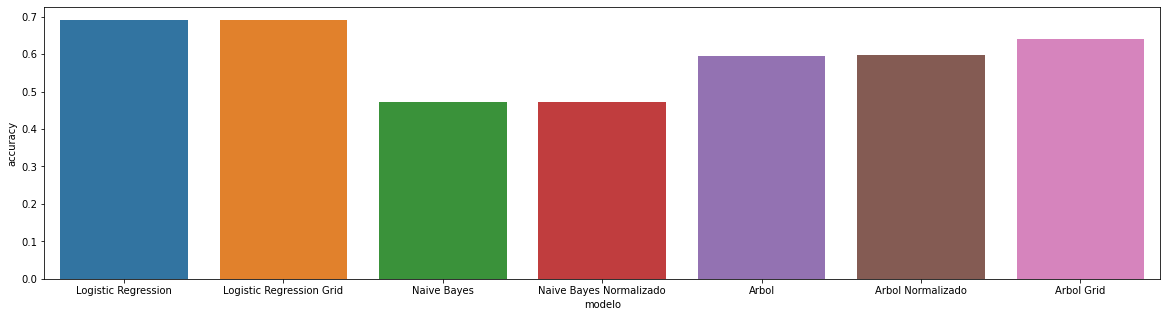

In [48]:
fig, ax = plt.subplots(figsize=(20,5)) 
ax = sns.barplot(x=resultados["modelo"], y=resultados["accuracy"])

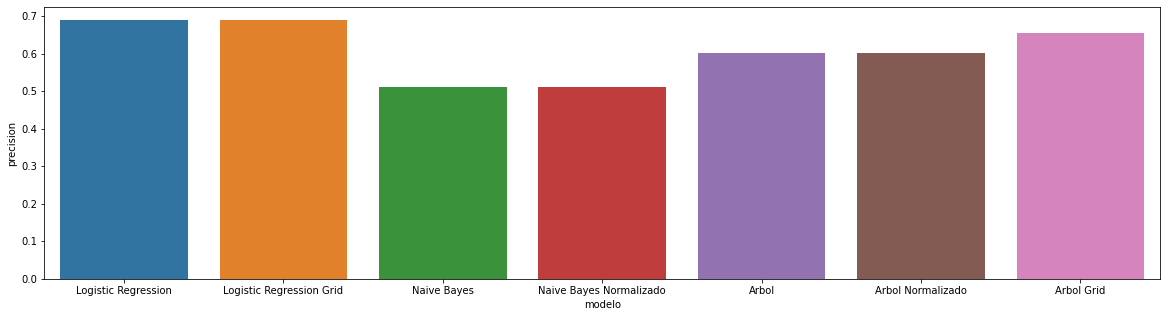

In [49]:
fig, ax = plt.subplots(figsize=(20,5)) 
ax = sns.barplot(x=resultados["modelo"], y=resultados["precision"])

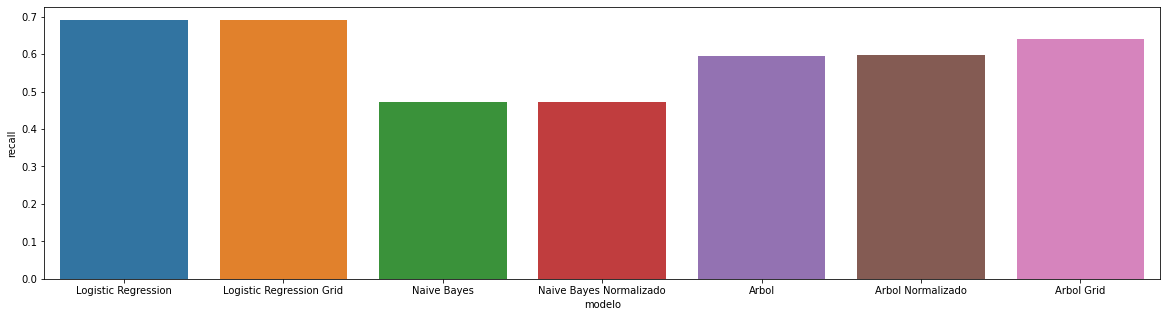

In [50]:
fig, ax = plt.subplots(figsize=(20,5)) 
ax = sns.barplot(x=resultados["modelo"], y=resultados["recall"])

----------------------------------

----------------------------------

# <b><a id="valence">2. Predicción de valencia</a></b>

In [51]:
X_valen = data.drop(columns=['genre', "valence"])
y_valen = data["valence"]

In [52]:
X_train_valen, X_test_valen, y_train_valen, y_test_valen = train_test_split(X_valen, y_valen, random_state = 0)

### Dummies

In [53]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
dummies = ohe.fit_transform(X_train_valen[["time_signature"]])

In [54]:
columns_dummies = []
for cat in ohe.categories_:
	columns_dummies.extend(cat[:])

In [55]:
dummies = pd.DataFrame(dummies, columns=columns_dummies, index=X_train_valen.index)

In [56]:
X_train_valen = X_train_valen.join(dummies)
X_train_valen = X_train_valen.drop(columns = ["time_signature"], axis=1)

In [57]:
dummies_test = ohe.transform(X_test_valen[["time_signature"]])

In [58]:
dummies_test = pd.DataFrame(dummies_test, columns=columns_dummies, index=X_test_valen.index)

In [59]:
X_test_valen = X_test_valen.join(dummies_test)
X_test_valen = X_test_valen.drop(columns = ["time_signature"], axis=1)

In [60]:
X_train_valen

,danceability,energy,loudness,mode,speechiness,instrumentalness,tempo,acousticness,l_ace_quantity,l_aga_quantity,...,joy_quantity,negative_quantity,positive_quantity,sadness_quantity,surprise_quantity,trust_quantity,1,3,4,5
491,0.906,0.597,-2.566,1,0.0764,0.000003,124.008,0.165000,0.0,0.0,...,5,4,10,4,3,7,0.0,0.0,1.0,0.0
2202,0.456,0.616,-9.164,1,0.0464,0.000000,199.031,0.487000,0.0,0.0,...,7,21,9,16,2,2,0.0,0.0,1.0,0.0
1368,0.477,0.951,-4.260,0,0.1580,0.442000,183.132,0.000019,0.0,0.0,...,26,65,27,23,5,21,0.0,0.0,1.0,0.0
2865,0.243,0.682,-9.355,0,0.0506,0.000002,148.538,0.001090,0.0,0.0,...,7,3,15,4,5,11,0.0,0.0,1.0,0.0
1815,0.736,0.294,-13.760,1,0.0365,0.022900,109.956,0.533000,0.0,0.0,...,6,1,7,1,0,0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.362,0.600,-12.285,1,0.0463,0.042600,148.462,0.001830,0.0,0.0,...,12,2,12,1,5,5,0.0,0.0,1.0,0.0
3264,0.592,0.516,-8.149,1,0.0291,0.211000,127.136,0.000092,0.0,0.0,...,15,91,36,40,11,28,0.0,0.0,1.0,0.0
1653,0.669,0.499,-10.593,1,0.0626,0.000000,96.809,0.293000,0.0,0.0,...,0,4,11,3,0,2,0.0,0.0,1.0,0.0
2607,0.258,0.920,-8.955,1,0.0574,0.000000,146.597,0.092000,0.0,2.0,...,3,16,7,13,0,6,0.0,0.0,1.0,0.0


In [61]:
print(X_train_valen.shape)
print(y_train_valen.shape)
print(X_test_valen.shape)
print(y_test_valen.shape)

(2583, 72)
(2583,)
(862, 72)
(862,)


----------------------------------

## <b><a id="elastic">2.1. ElasticNet</a></b>

In [62]:
baseline = sm.OLS(y_train_valen, sm.add_constant(X_train_valen)).fit()
baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     26.24
Date:                Tue, 09 Mar 2021   Prob (F-statistic):          4.12e-243
Time:                        16:52:46   Log-Likelihood:                 591.60
No. Observations:                2583   AIC:                            -1043.
Df Residuals:                    2513   BIC:                            -633.2
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.4262      0.036    -11.765      0.000      -0.497      -0.355
danceability              0.8471      0.028     29.810      0.000       0.791       0.903
energy                    0.5080      0.031     16.331      0.000       0.447       0.569
loudness                 -0.0099      0.002     -6.413      0.000      -0.013      -0.007
mode                      0.0039      0.009      0.455      0.649      -0.013       0.021
speechiness              -0.4361      0.068     -6.442      0.000      -0.569      -0.303
instrumentalness         -0.0638      0.020     -3.159      0.002      -0.103      -0.024
tempo                     0.0017      0.000     12.410      0.000       0.001       0.002
acousticness              0.1508      0.019      8.073      0.000       0.114       0.187
l_ace_quantity           -0.0061      0.002     -2.635      0.008      -0.011      -0.002
l_aga_quantity           -0.0314      0.014     -2.295      0.022      -0.058      -0.005
l_aid_quantity            0.0086      0.003      3.326      0.001       0.004       0.014
l_ally_quantity          -0.0076      0.004     -1.835      0.067      -0.016       0.001
l_art_quantity           -0.0003      0.001     -0.342      0.732      -0.002       0.001
l_ay_quantity            -0.0004      0.001     -0.574      0.566      -0.002       0.001
l_baby_quantity           0.0004      0.002      0.247      0.805      -0.003       0.003
l_dance_quantity          0.0007      0.002      0.316      0.752      -0.004       0.005
l_don_quantity            0.0026      0.004      0.732      0.464      -0.004       0.010
l_eat_quantity            0.0007      0.002      0.420      0.674      -0.002       0.004
l_fore_quantity          -0.0100      0.004     -2.705      0.007      -0.017      -0.003
l_gain_quantity           0.0297      0.014      2.151      0.032       0.003       0.057
l_god_quantity           -0.0095      0.004     -2.679      0.007      -0.017      -0.003
l_good_quantity           0.0024      0.002      1.081      0.280      -0.002       0.007
l_king_quantity           0.0017      0.002      1.126      0.260      -0.001       0.005
l_love_quantity          -0.0008      0.001     -0.614      0.539      -0.003       0.002
l_real_quantity           0.0018      0.004      0.480      0.631      -0.005       0.009
l_rock_quantity           0.0038      0.002      2.527      0.012       0.001       0.007
l_sing_quantity          -0.0026      0.003     -0.946      0.344      -0.008       0.003
l_star_quantity          -0.0022      0.004     -0.577      0.564      -0.010       0.005
l_sun_quantity            0.0037      0.004      0.954      0.340      -0.004       0.011
l_top_quantity            0.0013      0.002      0.686      0.493      -0.002       0.005
l_wit_quantity        -

----------------------------------

## <b><a id="lasso">2.2. Lasso</a></b>

In [63]:
kf = KFold(shuffle=True, random_state=10)

In [64]:
model_skl_LassoCV = linear_model.LassoCV(alphas=np.linspace(0.0001,0.01, 100), cv=kf, normalize=True)
model_skl_LassoCV.fit(X_train_valen, y_train_valen)
print("Alpha óptimo:", model_skl_LassoCV.alpha_)
print("R2 Lasso de entrenamiento:",model_skl_LassoCV.score(X_train_valen, y_train_valen).round(3))

Alpha óptimo: 0.0001
R2 Lasso de entrenamiento: 0.391


In [65]:
betas = pd.DataFrame(data= model_skl_LassoCV.coef_ , index=X_train_valen.columns, columns=['Betas'])

betas_0_mask = betas.Betas == 0
print("Variables igualadas a 0 por Lasso:", betas_0_mask.sum())

Variables igualadas a 0 por Lasso: 40


In [66]:
betas.sort_values(by = "Betas", ascending = False)

,Betas
danceability,0.785333
energy,0.345381
acousticness,0.103838
joy,0.067517
4,0.009854
...,...
fear,-0.010825
instrumentalness,-0.029835
negative,-0.042126
anger,-0.122801


----------------------------------

## <b><a id="ridge">2.3. Ridge</a></b>

In [67]:
model_skl_RidgeCV = linear_model.RidgeCV(alphas=np.linspace(0.001,0.1, 100), cv=kf, normalize=True)
model_skl_RidgeCV.fit(X_train_valen, y_train_valen)
print("Alpha óptimo:", model_skl_RidgeCV.alpha_)
print("R2 Ridge de entrenamiento:",model_skl_RidgeCV.score(X_train_valen, y_train_valen).round(3))

Alpha óptimo: 0.022000000000000002
R2 Ridge de entrenamiento: 0.417


----------------------------------

### Predicción Lasso

In [68]:
prediction_lasso = model_skl_LassoCV.predict(X_test_valen)

Text(0.5, 0, 'Y_test')

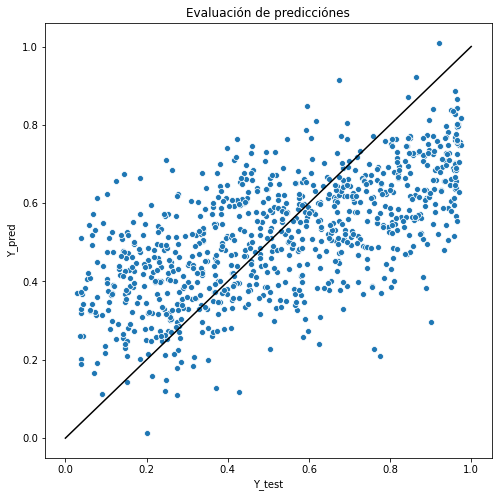

In [69]:
plt.figure(figsize=(8,8))
sns.scatterplot(y_test_valen, prediction_lasso)
sns.lineplot([0,1],[0,1],color='black')
plt.title("Evaluación de predicciónes")
plt.ylabel("Y_pred")
plt.xlabel("Y_test")

----------------------------------

#### Resumen de resultados de los modelos de regresión

In [70]:
#ElasticNet
resultados_elasticnet = [["ElasticNet", 
                          r2_score(y_test_valen, baseline.predict(sm.add_constant(X_test_valen))), 
                          r2_score(y_train_valen, baseline.predict(sm.add_constant(X_train_valen)))
                         ]]
resultados_valen = pd.DataFrame(resultados_elasticnet, columns=["modelo", "r2_test", "r2_train"])

#Lasso
resultados_lasso = [["Lasso", r2_score(y_test_valen, model_skl_LassoCV.predict(X_test_valen)), r2_score(y_train_valen, model_skl_LassoCV.predict(X_train_valen))]]
resultados_lasso_df = pd.DataFrame(resultados_lasso, columns=["modelo", "r2_test", "r2_train"])

#Ridge
resultados_ridge = [["Ridge", r2_score(y_test_valen, model_skl_RidgeCV.predict(X_test_valen)), r2_score(y_train_valen, model_skl_RidgeCV.predict(X_train_valen))]]
resultados_ridge_df = pd.DataFrame(resultados_ridge, columns=["modelo", "r2_test", "r2_train"])

#Tabla final
resultados_valen = resultados_valen.append([resultados_lasso_df, resultados_ridge_df])
resultados_valen.reset_index(drop=True, inplace=True)

In [71]:
resultados_valen

,modelo,r2_test,r2_train
0,ElasticNet,0.387852,0.418723
1,Lasso,0.398177,0.390603
2,Ridge,0.390729,0.416910


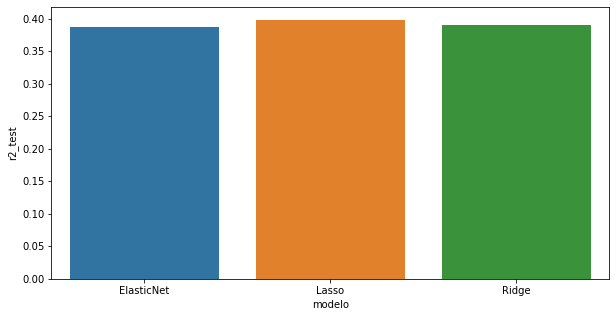

In [72]:
fig, ax = plt.subplots(figsize=(10,5)) 
ax = sns.barplot(x=resultados_valen["modelo"], y=resultados_valen["r2_test"])

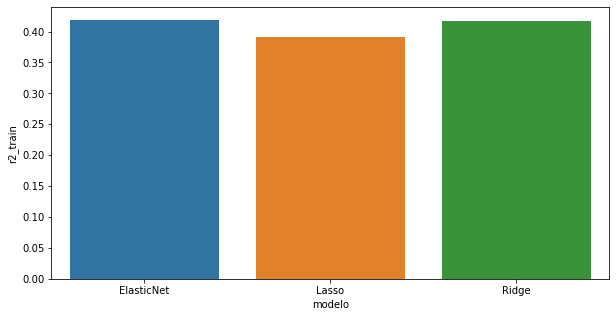

In [73]:
fig, ax = plt.subplots(figsize=(10,5)) 
ax = sns.barplot(x=resultados_valen["modelo"], y=resultados_valen["r2_train"])